In [1]:
#Importing Libraries
#Data Handling
import pandas as pd
import numpy as np

import sys
sys.path.append('../../')

from source import *
import source.fairness as fm
import source.pipes as op
import source.utils as ut
from source.estimators import FORESEE

#Storing trains
import pickle

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2


In [2]:
#Run following codes for loading pipelines on dictionary from pickles
path_dir = '../../pipes/compas-recid/fairness/'
preprocessing_pickles = op.import_pickle(path_dir + 'preprocessing.pickle')
preprocessing_pickles_norm = op.import_pickle(path_dir + 'preprocessing_norm.pickle')
y = op.import_pickle(path_dir + 'y.pickle')
data_test_prepro = op.import_pickle(path_dir + 'preprocessing_test.pickle')
data_test_prepro_norm = op.import_pickle(path_dir + 'preprocessing_test_norm.pickle')
A = op.import_pickle(path_dir + 'A.pickle')
aware_features = op.import_pickle(path_dir + 'preprocessing_features_aware.pickle')
race_features = op.import_pickle(path_dir + 'preprocessing_features_race.pickle')


In [3]:
#Run this for creating dictionary of datasets, nompipelines, and numpipelines
#remember: transf means data normalized and scaled.
datasets_prepro = {}
datasets_prepro_norm = {}
pipes_nominal = {}
pipes_numerical = {}
y_train = {}
y_test = {}
A_train = {}
A_test = {}

for p in preprocessing_pickles_norm:
    d , pnom, pnum = preprocessing_pickles_norm[p]
    datasets_prepro_norm[p] = d

for p in preprocessing_pickles:
    d , pnom, pnum = preprocessing_pickles[p]
    datasets_prepro[p] = d
    pipes_nominal[p] = pnom
    pipes_numerical[p] = pnum
    
for yval in y:
    if 'train' in yval:
        y_train[yval.replace('train_','')] = y[yval]
    if 'test' in yval:
        y_test[yval.replace('test_','')] = y[yval]
    
for Aval in A:
    if 'train' in Aval:
        A_train[Aval.replace('train_','')] = A[Aval]
    if 'test' in Aval:
        A_test[Aval.replace('test_','')] = A[Aval]
        
#Get in a dictionary all preprocessed datasets.
#Deberia llamarse datasets_train
datasets_train = {}
for d in datasets_prepro:
    ds = datasets_prepro[d]
    datasets_train[d] = ds
    
#Deberia llamarse datasets_norm_train
datasets_norm_train = {}
for d in datasets_prepro_norm:
    ds = datasets_prepro_norm[d]
    datasets_norm_train[d] = ds
    
#Get in a dictionary all preprocessed datasets.
datasets_test = {}
for d in data_test_prepro:
    ds = data_test_prepro[d]
    datasets_test[d] = ds
datasets_test.keys()

datasets_norm_test = {}
for d in data_test_prepro_norm:
    ds = data_test_prepro_norm[d]
    datasets_norm_test[d] = ds


In [4]:
X_t  = datasets_train['race'].toarray()
A_t = np.array(A_train['race']['race'])
X_t_A = np.concatenate((X_t, 1*(A_t.reshape(-1,1)=='Caucasian')), axis=1)
y_t = np.array(y_train['race']['two_year_recid'])

In [15]:
fsee= FORESEE(min_samples_leaf=[2])
fsee.fit(X=X_t_A,
         A=A_t,
         priv_class='Caucasian',
         y=y_t,
         k=400,
         scoring=['accuracy'])

Complete                    

In [16]:
risks_train, disc_acc_train, count_disc_train = fsee.risk_disc(X=X_t_A,
                                                               y=y_t,
                                                               A=A_t,
                                                               priv_class='Caucasian', 
                                                               beta=0.57)


In [5]:
X_tt  = datasets_test['race'].toarray()
A_tt = np.array(A_test['race']['race'])
X_tt_A = np.concatenate((X_tt, 1*(A_tt.reshape(-1,1)=='Caucasian')), axis=1)
y_tt = np.array(y_test['race']['two_year_recid'])

In [18]:
risks_test, disc_acc_test, count_disc_test = fsee.risk_disc(X=X_tt_A,
                                                            y=y_tt,
                                                            A=A_tt,
                                                            priv_class='Caucasian', 
                                                            beta=0.57)


In [19]:
#checkpoints
with open('checkpoints/risks_train.pickle', 'wb') as f:
    pickle.dump(risks_train, f, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('checkpoints/risks_test.pickle', 'wb') as f:
    pickle.dump(risks_test, f, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
risks_train = op.import_pickle('checkpoints/risks_train.pickle')
risks_test = op.import_pickle('checkpoints/risks_test.pickle')

# Analayzing Results

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


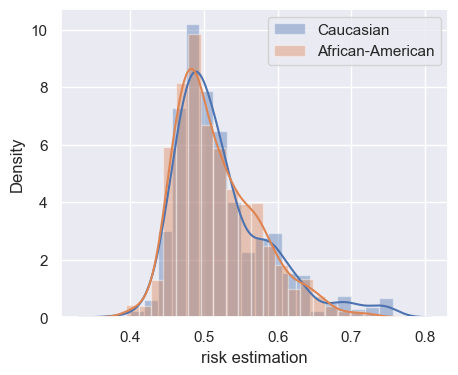

In [9]:
plt.figure(figsize=(5, 4))
sns.distplot(risks_test['th_beta'][A_tt=='Caucasian'], hist=True, kde=True, bins=20, label='Caucasian')
sns.distplot(risks_test['th_beta'][A_tt=='African-American'], hist=True, kde=True, bins=20, label='African-American')
plt.xlabel('risk estimation')
plt.legend()
plt.show()

# Models

In [10]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [11]:
#Obtain the X, Y and risk
X_train_models = datasets_norm_train['race'].toarray()
X_test_models = datasets_norm_test['race'].toarray()

In [24]:
parameters = {'LR__C':[0.01, 0.1, 1], 'LR__fit_intercept':[True, False], 'LR__solver': ['liblinear','lbfgs'], 'LR__class_weight': [None,'balanced'], 'LR__max_iter' : [100000]}
lr = LogisticRegression(random_state=0)
fit_lr = op.get_grid(X_train_models, y_t, parameters, lr, 'LR', scoring=['accuracy'], refit='accuracy')


In [25]:
parameters = {'RF__class_weight': ['balanced'],'RF__n_estimators':[10, 50, 100], 'RF__criterion': ['gini', 'entropy'], 'RF__max_depth': [None, 5, 10, 15]}
rf = RandomForestClassifier(random_state=0)

fit_rf = op.get_grid(X_train_models, y_t, parameters, rf, 'RF', scoring=['accuracy'], refit='accuracy')


In [26]:
parameters = {'KNN__weights': ['uniform', 'distance'],'KNN__n_neighbors': [5, 10, 15, 20, 25, 30]}
knn = KNeighborsClassifier()

fit_knn = op.get_grid(X_train_models, y_t, parameters, knn, 'KNN', scoring=['accuracy'], refit='accuracy')
        

In [27]:
parameters = {'SVM__probability':[True],'SVM__kernel':['rbf', 'sigmoid', 'poly'], 'SVM__C': [0.001, 0.01, 1, 10, 100], 'SVM__class_weight': [None,'balanced']}
svm = SVC(random_state=0)
fit_svm = op.get_grid(X_train_models, y_t, parameters, svm, 'SVM', scoring=['accuracy'], refit='accuracy')


In [12]:
#MLP
parameters = {'MLP__hidden_layer_sizes':
                                [(10, 10), (10, 100), (10, 500),
                                (100, 10), (100, 100), (100, 500),
                                (500, 10), (500, 100), (500, 500)],
            'MLP__learning_rate_init': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
            'MLP__max_iter': [1000],
            'MLP__tol': [1e-4]},
mlp = MLPClassifier(random_state=0)

fit_mlp = op.get_grid(X_train_models, y_t, parameters, mlp, 'MLP', scoring=['f1'], refit='f1')

In [17]:
models = {'LR': fit_lr,
        'RF': fit_rf,
        'KNN': fit_knn,
        'SVM': fit_svm,
        'MLP': fit_mlp}


In [18]:
models_results = pd.DataFrame(columns=['model','performance','eq_opp','eq_odd','dem_p'])

for m in models:
    clf = models[m].best_estimator_[m]
    y_pred = clf.predict(X_test_models)

    perfo = fm.accuracy(y_tt, y_pred)
    eq_opp = fm.equal_opp_dif(y_tt, y_pred, A_tt, 'Caucasian')
    eq_odd = fm.equalized_odd_dif(y_tt, y_pred, A_tt, 'Caucasian')
    dem_p = fm.demographic_parity_dif(y_pred, A_tt,'Caucasian')

    new_r = {'model': m,
             'performance': perfo,
             'eq_opp': eq_opp,
             'eq_odd': eq_odd,
             'dem_p': dem_p}

    models_results = models_results.append(new_r, ignore_index=True)
models_results

,model,performance,eq_opp,eq_odd,dem_p
0,LR,0.655210,0.221168,0.189726,0.213960
1,RF,0.668303,0.178221,0.174432,0.204852
2,KNN,0.650846,0.177925,0.167893,0.193510
3,SVM,0.655210,0.180223,0.170191,0.196691
4,MLP,0.641571,0.148600,0.142443,0.166691


In [19]:
with open('checkpoints/models.pickle', 'wb') as f:
    pickle.dump(models, f, protocol = pickle.HIGHEST_PROTOCOL)

In [14]:
models = op.import_pickle('checkpoints/models.pickle')

In [16]:
fit_lr = models['LR']
fit_rf = models['RF']
fit_knn = models['KNN']
fit_svm = models['SVM']


# Finding High and Low Risk Groups

In [20]:
threshold = .5

X_train_high = X_train_models[risks_train['th_beta']>=threshold]
y_train_high = y_t[risks_train['th_beta']>=threshold]
A_train_high = A_t[risks_train['th_beta']>=threshold]

X_train_low = X_train_models[risks_train['th_beta']<threshold]
y_train_low = y_t[risks_train['th_beta']<threshold]
A_train_low = A_t[risks_train['th_beta']<threshold]

X_test_high = X_test_models[risks_test['th_beta']>=threshold]
y_test_high = y_tt[risks_test['th_beta']>=threshold]
A_test_high = A_tt[risks_test['th_beta']>=threshold]

X_test_low = X_test_models[risks_test['th_beta']<threshold]
y_test_low = y_tt[risks_test['th_beta']<threshold]
A_test_low = A_tt[risks_test['th_beta']<threshold]


In [22]:
models_results_both = pd.DataFrame(columns=['model','scenario','performance','eq_opp','eq_odd','dem_p'])
scenario = ['high','low']

for m in models.keys():
    for s in scenario:
        if s == 'high':
            X_test_model = X_test_high
            y_test_model = y_test_high
            A_test_model = A_test_high
        else:
            X_test_model = X_test_low
            y_test_model = y_test_low
            A_test_model = A_test_low

        clf =  models[m].best_estimator_[m]
        y_pred = clf.predict(X_test_model)

        perfo = fm.f1score(y_test_model, y_pred)
        eq_opp = fm.equal_opp_dif(y_test_model, y_pred, A_test_model, 'Caucasian')
        eq_odd = fm.equalized_odd_dif(y_test_model, y_pred, A_test_model, 'Caucasian')
        dem_p = fm.demographic_parity_dif(y_pred, A_test_model, 'Caucasian')

        new_r = {'model': m,
                'scenario': s,
                'performance': perfo,
                'eq_opp': eq_opp,
                'eq_odd': eq_odd,
                'dem_p': dem_p}

        models_results_both = models_results_both.append(new_r, ignore_index=True)
models_results_both

,model,scenario,performance,eq_opp,eq_odd,dem_p
0,LR,high,0.595918,0.291449,0.196132,0.215180
1,LR,low,0.619750,0.164003,0.194279,0.206349
2,RF,high,0.596932,0.306100,0.203604,0.222216
3,RF,low,0.667362,0.077193,0.161629,0.174389
4,KNN,high,0.585227,0.320697,0.206386,0.220971
5,KNN,low,0.600917,0.057635,0.145387,0.154440
6,SVM,high,0.591231,0.287582,0.193325,0.213471
7,SVM,low,0.608000,0.091033,0.159941,0.170099
8,MLP,high,0.582496,0.287473,0.186860,0.204725
9,MLP,low,0.570423,0.029695,0.108992,0.115830


# Profiles

In [17]:
aware_dataset = pd.DataFrame(data_test_prepro['race'].toarray(), columns=race_features)
race_dataset = pd.DataFrame(1*(A_tt=='Caucasian'), columns=['race']) #if 1, then Caucasian
risk_dataset = pd.DataFrame(risks_test['th_beta'], columns=['risk'])
label_dataset = pd.DataFrame(y_tt, columns = ['label'])
bins = pd.DataFrame(np.zeros((y_tt.shape[0])), columns = ['bins'])
profile_dataset = pd.concat([aware_dataset, race_dataset, risk_dataset, label_dataset, bins], axis=1)
#Scaled and standardize all variables
for i in range(len(profile_dataset.columns)-4):
    profile_dataset.iloc[:,i]=(profile_dataset.iloc[:,i]-profile_dataset.iloc[:,i].mean())/(profile_dataset.iloc[:,i].std())
     
profile_dataset

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_days_jail,sex,age_cat,c_charge_degree,race,risk,label,bins
0,-0.972382,-0.163605,-0.172063,-0.252707,-0.738268,-0.309693,0.501056,1.649214,-0.736636,0,0.521294,0,0.0
1,-1.056742,-0.163605,-0.172063,-0.252707,-0.119123,0.331377,0.501056,1.649214,-0.736636,0,0.510797,0,0.0
2,0.039948,-0.163605,-0.172063,-0.252707,0.500023,-0.329727,0.501056,-0.803532,-0.736636,0,0.464759,0,0.0
3,-0.719299,-0.163605,1.532760,-0.252707,1.325550,-0.309693,0.501056,-0.803532,-0.736636,0,0.519698,1,0.0
4,-1.225464,-0.163605,3.237583,1.911833,-0.119123,-0.329727,-1.994695,1.649214,1.356781,1,0.416429,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1828,-1.141103,-0.163605,-0.172063,-0.252707,-0.531886,-0.309693,0.501056,1.649214,-0.736636,0,0.515901,1,0.0
1829,-0.634938,-0.163605,-0.172063,-0.252707,-0.325504,-0.329727,-1.994695,-0.803532,1.356781,0,0.507447,1,0.0
1830,-0.719299,-0.163605,-0.172063,-0.252707,-0.738268,-0.169459,0.501056,-0.803532,1.356781,1,0.574716,0,0.0
1831,-1.141103,2.865573,3.237583,4.076373,-0.119123,-0.329727,0.501056,1.649214,-0.736636,0,0.430831,1,0.0


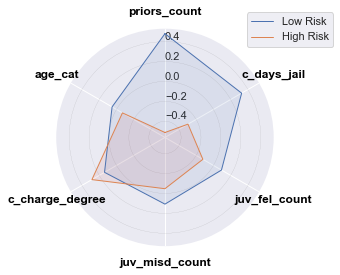

In [18]:
#Plot
numbers_features = 6
features = profile_dataset.columns
bins = 5
priv = 1
sens_attr = 'race'
ascending = True

profile_dataset_result, ds_radarchart_result, categories = ut.plotProfiles(profile_dataset=profile_dataset, 
                                                 numbers_features=numbers_features, 
                                                 features=features, 
                                                 bins=bins, 
                                                 priv=priv, 
                                                 sens_attr=sens_attr, 
                                                 ascending=ascending)

In [19]:
ds_radarchart_result

,priors_count,c_days_jail,juv_fel_count,juv_misd_count,c_charge_degree,age_cat
bins,,,,,,
1.0,0.479723,0.326615,0.092964,0.107416,0.138481,0.050908
2.0,0.118273,0.097161,-0.031182,-0.004376,-0.141785,0.010699
3.0,0.083312,-0.018114,0.126070,-0.041640,-0.239021,-0.069719
4.0,-0.164797,-0.108155,-0.064288,-0.013692,-0.044550,0.077714
5.0,-0.512311,-0.295089,-0.122560,-0.047320,0.284543,-0.069037


In [20]:
pd.pivot_table(profile_dataset_result, values=['race'], index=['bins'])

,race
bins,
1.0,0.398907
2.0,0.398907
3.0,0.398907
4.0,0.398907
5.0,0.403794


In [21]:
pd.pivot_table(profile_dataset_result, values=['label'], index=['bins'])

,label
bins,
1.0,0.546448
2.0,0.530055
3.0,0.478142
4.0,0.461749
5.0,0.311653
